# 3.1_MNIST数字识别

获取通用的MNIST数据集

In [48]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784',version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [49]:
X,y = mnist["data"],mnist["target"]    #图片数据和其代表的数字
X.shape       #数据集中有70000个行，一行代表一个手写数字实例，一行有28*28=784列，

(70000, 784)

In [50]:
y.shape       #手写数字的结果

(70000,)

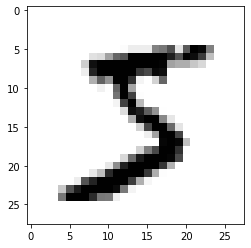

In [51]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image,cmap="binary")
plt.axis("on")
plt.show()

In [52]:
y[0]

'5'

In [53]:
import numpy as np
y = y.astype(np.uint8)    #将y转化为算法喜欢的整型

In [54]:
#测试集和训练集的分割
X_train,X_test,y_train,y_test = X[:60000],X[60000:],y[:60000],y[60000:]

# 3.2_训练二元分类器

简化问题，先区分5和非5

In [55]:
#创建目标向量
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

## SGDClassifier():sklearn中随机梯度下降（SGD）分类器

In [11]:
# 用训练集训练模型
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train,y_train_5)

SGDClassifier(random_state=42)

In [12]:
# 尝试检测
sgd_clf.predict([some_digit])

array([ True])

分类认为这个图像是数字5，它猜对了！

# 3.3.1_性能测量（用交叉验证测量准确率）

## 自定义实现交叉验证的方法（交叉验证原理解析）

In [13]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3,random_state=42)    #每个折叠进行分层抽样

for train_index,test_index in skfolds.split(X_train,y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]       #训练集中的训练集折叠
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]          #训练集中的测试集折叠
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds,y_train_folds)       #适配中
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))             #计算正确率

C:\Users\Administrator\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


0.95035
0.96035
0.9604


## K-折交叉验证法：cross_val_score()函数

将训练集分成k组，每次留其中一组进行预测，剩余进行训练

In [23]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf,X_train,y_train_5,cv=3,scoring="accuracy")   #每组的准确率

array([0.95035, 0.96035, 0.9604 ])

### 所以，这说明准确率无法成为分类器的首要测量标准！！！尤其是两者差距较大时（eg.是5为10%，非5为90%）

# 3.3.2_混淆矩阵

总体思路：统计A类别被分类到B类别中的次数

## cross_val_predict()函数:K-折交叉验证法，
区别于cross_val_score()函返回评估分数，此函数返回每个折叠的预测

In [22]:
#要计算混淆矩阵，需要现有一组预测的数据，然后让预测数据和目标数据进行比较
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf,X_train,y_train_5,cv=3)

## confusion_matrix()函数:sklearn框架中获取混淆矩阵的函数（传入的参数为目标数据和预测数据）

In [25]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5,y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

解析：
    
    行代表真实的类别（第一行为实际的假，第二行为实际的真）
    
    列代表预测的类别（第一列为预测为假的数据，第二列为预测为帧的数据）

所以分析该混淆矩阵可以得出：
    
    53892条实例实际为假，预测也为假；矩阵中坐标(0,0)，TN表示
    
    687条实例实际为假，但预测为真；矩阵中坐标(0,1)，FP表示
    
    1891条实例实际真，但预测为假；矩阵中坐标(1,0)，FN表示
    
    3530条实例实际为真，预测也为真；矩阵中坐标(1,1)，TP表示
    
   （此案例中‘真’代表‘是5’；‘假’代表‘非5’）

### 为了使指标更直观一些，以下是两个衡量的指标，两者经常结合使用：（此处为自定义求解，重在原理）

### 精度：

$$ 精度= \frac{TP}{TP+FP}$$

预测准确率：所有预测为真的实例中，实际也为真所占比例

### 召回率：

$$ 召回率= \frac{TP}{TP+FN}$$ 

灵敏度：正确检测到正类实例的比率；所有实际为真的实例中，有多少被分类器检测到了

# 3.3.3_精度和召回率

In [26]:
from sklearn.metrics import precision_score,recall_score

precision_score(y_train_5,y_train_pred)   #精度

0.8370879772350012

In [38]:
recall_score(y_train_5,y_train_pred)     #召回率

0.6511713705958311

现在看来这个针对数字5的二元分类器的准确率就没有那么高了，当一张图片是5时，只有83.7%的概率是准确的，并且也只有65%的数字5被检测出来

更为经常的使用中我们会将精度和召回率合成一个指标，即F1分数

## F1分数：分类器验证中更为常用的衡量指标（精度和召回率的谐波平均值）

谐波平均值：相比正常的平均值而言会给予低值更高的权重；因此只有精度和召回率都很高时才会得到较高的F1分数

$$ F_1= \frac{2}{\frac{1}{精度}+\frac{1}{召回率}}=2*\frac{精度*召回率}{精度+召回率}=\frac{TP}{TP+\frac{FN+FP}{2}}$$

In [28]:
from sklearn.metrics import f1_score

f1_score(y_train_5,y_train_pred)

0.7325171197343846

### 但是！！在实际中精度和召回率都很高的情况很难达到，所以需要根据实际问题进行权衡两者

# 3.3.4_精度/召回率权衡

## 分类器的决策原理：

    以SDGClassifier()分类器为例，分类器会对每个实例计算出一个分值，同时设置一个阈值，大于就位正类，否则就是负类。我们可以通过调整分类器的阈值来改变精度和召回率，二者的变化大多呈此消彼长的趋势。

## decision_function():返回每个实例的决策得分

sklearn框架下不允许直接更改阈值，所以用这种方法返回每个实例的得分，并且对照这些得分使用阈值进行预测

In [31]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores      #某个实例的得分

array([2164.22030239])

In [33]:
threshold = 0    #阈值
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

SDGClassifier分类器使用的阈值为0，所以上方代码与sklearn原有的predict()函数预测的结果是一样的

In [36]:
threshold = 8000    #重新设置阈值
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

 发现提高阈值的确可以降低召回率，但是阈值过高会导致错过一些实例，所以我们要适当的调整阈值

# 如何决定使用什么阈值？

首先，获取所有实例的得分（注意不是预测结果，而是有关决策分类的得分）

In [37]:
y_scores = cross_val_predict(sgd_clf,X_train,y_train_5,cv=3,method='decision_function')

## precision_recall_curve()函数：计算所有可能的阈值的精度和召回率

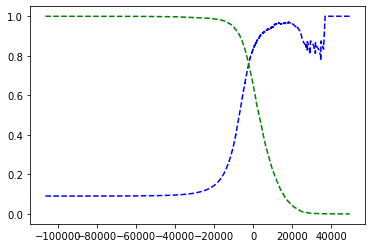

In [44]:
from sklearn.metrics import precision_recall_curve
%matplotlib inline
import matplotlib.pyplot as plt

precisions,recalls,thresholds = precision_recall_curve(y_train_5,y_scores)   #精度、召回率、阈值

def plot_precision_recall_vs_threshold(precisions,recalls,thresholds):
    plt.plot(thresholds,precisions[:-1],"b--",label="Precision")
    plt.plot(thresholds,recalls[:-1],"g--",label="Recall")

plot_precision_recall_vs_threshold(precisions,recalls,thresholds)
plt.show()

# 3.3.5_ROC曲线

# 3.4_多类分类器

对于多类分类器，有一些算法（例如随机森林分离器或朴素贝叶斯分类器）可以直接处理多个类，也有一些严格的二元分类（如支持向量机和线性分类）；
同时也可以用几个二元分类器实现多类分类的目的，以下就是这样的一些解法。

# 对于用几个二元分类器实现多类分类的目的共有两种方法：

## ①一对多(OvR)策略：

如果要分成n类，就创建n个二元分类器，每个分类器将这个类与剩余进行分类，实例在哪个分类器上的决策得分越高就被分到哪一类

## ②一对一(OvO)策略；

每两个分类之间建立一个二元分类器,如果有n类，那么就会有n*(n-1)/2个分类，最后看哪个类获胜的多

注意：大多数分类器最好使用OvR比较好，有些算法在数规模扩大时效果不好，可以选择OvO策略

In [58]:
#尝试使用支持向量机（SVM）分类器进行分类
from sklearn.svm import SVC

svm_clf = SVC()
svm_clf.fit(X_train,y_train)
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [59]:
#生成与索引为'some_digit'的对象的分数，与10个类别的决策分数
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [61]:
np.argmax(some_digit_scores)

5

In [62]:
svm_clf.classes_    #类别

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

## OneVsOneClassifier或OneVsRestClassifier类：指定sklearn强制使用OvO或OvR策略

In [65]:
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train,y_train)
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [66]:
len(ovr_clf.estimators_)

10

训练随机梯度下降（SGDClassifier）或随机森林（RandomForestClassifier）同样简单:

In [67]:
#SGD就不用运行OvR或OvO了，可以直接分成多个类
sgd_clf.fit(X_train,y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [68]:
sgd_clf.decision_function([some_digit])    #SGD的‘some_digit’下各类的决策得分

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [70]:
#交叉验证评估准确率
cross_val_score(sgd_clf,X_train,y_train,cv=3,scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

将输入进行简单缩放可以一定程度的提高准确率:

In [73]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf,X_train_scaled,y_train,cv=3,scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

# 3.5_误差分析

如果已经找到了一个有潜力的模型，那么应该分析其发生错误的类型

In [75]:
y_train_pred = cross_val_predict(sgd_clf,X_train_scaled,y_train,cv=3)
conf_mx = confusion_matrix(y_train,y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]],
      dtype=int64)

将矩阵的数值转化成图块颜色的深浅，以更直观的看到错误类型

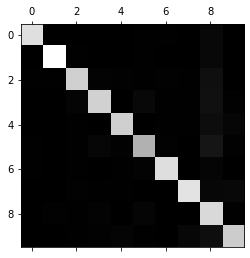

In [76]:
#@matplotlib inline
plt.matshow(conf_mx,cmap=plt.cm.gray)
plt.show()

分析图片，大多数都在主对角线上，主对角线的类别代表正确的被分到正确的类中以及错误的被分到了错误的类中，总体上表现的还不错，只有数字5相比其他有些暗

接下来需要将焦点放在错误上:

In [78]:
#将混淆矩阵中的每个值除以相应类中的图片数量的和（每行中的每个值除以行的和）从而得出错误率而不是绝对值
row_sums = conf_mx.sum(axis=1,keepdims=True)
norm_conf_mx = conf_mx / row_sums

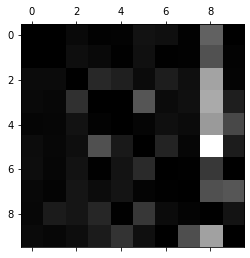

In [79]:
#用0填充对角线，让错误更加明显的显示出来（灵敏度提高）
np.fill_diagonal(norm_conf_mx,0)
plt.matshow(norm_conf_mx,cmap=plt.cm.gray)
plt.show()

#### 第8列相比其它亮很多，可以说明有很多图片被错误的识别成了8，然而实际上又有大部分的8被正确的识别了，说明错误不是完全对称的

#### 分析混淆矩阵通常可以很大的帮助你深入了解怎么改改机分类器

分析单个的错误可以帮助我们举一反三洞察其它的错误，以数字3和数字5的类别为例：

NameError: name 'imshow' is not defined

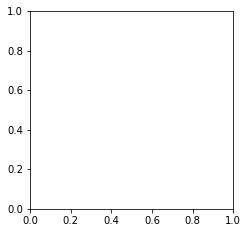

In [82]:
#按照混淆矩阵的位置打印
cl_a,cl_b = 3,5
X_aa = X_train[(y_train == cl_a)&(y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a)&(y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b)&(y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b)&(y_train_pred == cl_b)]
plt.figure(figsize=(8,8))
plt.subplot(221);plot_digits(X_aa[:25],images_per_row=5)
plt.subplot(222);plot_digits(X_ab[:25],images_per_row=5)
plt.subplot(223);plot_digits(X_ba[:25],images_per_row=5)
plt.subplot(224);plot_digits(X_bb[:25],images_per_row=5)
plt.show()

# 3.6_多标签分类器

 每个实例输出多个类

In [83]:
from sklearn.neighbors import KNeighborsClassifier

#输出的两个类分别代表：是否大于等于7；是否是奇数
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large,y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train,y_multilabel)

KNeighborsClassifier()

In [85]:
knn_clf.predict([some_digit])     #输出结果正确

array([[False,  True]])

In [87]:
#测量每个标签的F1分数，并取平均数，从而得到多标签分类器整体的F1分数
y_train_knn_pred = cross_val_predict(knn_clf,X_train,y_multilabel,cv=3)
f1_score(y_multilabel,y_train_knn_pred,average="macro")

0.976410265560605

上述代码假设两个标签同等重要（取平均值），改变权重只需要改变average成'weighted'就可以了

# 3.7_多输出分类

 也被称为多输出多类分类，是多标签的泛化，其标签也可以是多类的

以下为案例，构建一张模糊的图片，然后对他进行处理

In [88]:
#注意：这个分类器的输出是多个标签，一个标签代表一个像素点
noise = np.random.randint(0,100,(len(X_train),784))
X_train_mod = X_train + noise
noise = np.random.randint(0,100,(len(X_test),784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [89]:
knn_clf.fit(X_train_mod,y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)

NameError: name 'some_index' is not defined